# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [7]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%matplotlib notebook

# Import paths

In [9]:
def print_list(l):
    for item in l:
        print(item)

In [10]:
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/1/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/2/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/3/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/4/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/5/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/6/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044/7/stat.np

# Import data

In [11]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.0,
    new_or_old_suite2p='old',
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[72,72],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='mimg',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 14 stat files into class as self.statFiles. Total number of ROIs: 7047. Number of ROI from each file: [542, 470, 610, 541, 517, 386, 486, 529, 533, 512, 519, 469, 458, 475]


14it [00:00, 42.73it/s]

Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images


Imported 14 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


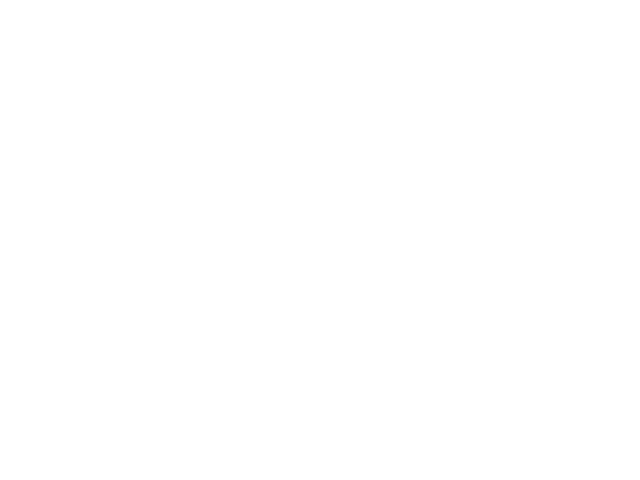

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


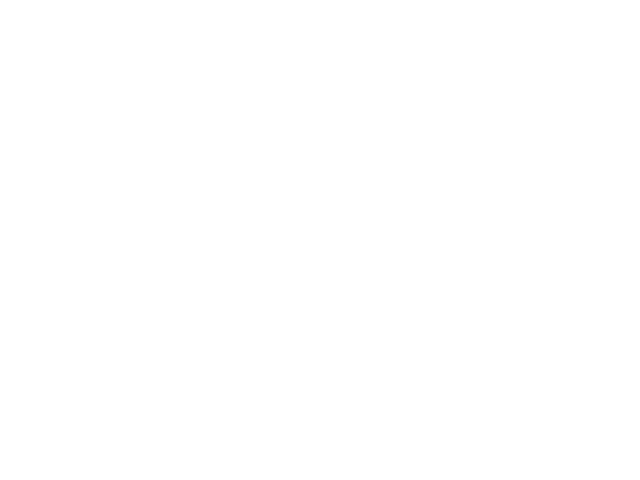

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


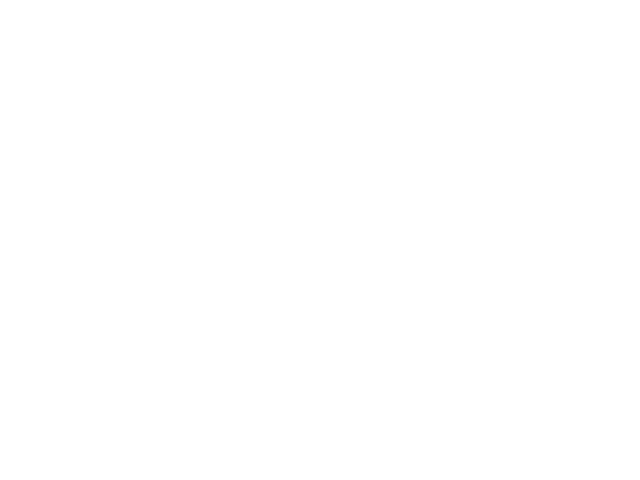

interactive(children=(IntSlider(value=0, description='i_frame', max=7046), Output()), _dom_classes=('widget-in…

In [12]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [ ]:
pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    im_template=data.FOV_images[6],
    ims_moving=data.FOV_images
);

In [14]:
FOVs_clahe = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]]

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=FOVs_clahe[6],
    FOVs=FOVs_clahe,
    ROIs=data.spatialFootprints,
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████| 14/14 [00:31<00:00,  2.25s/it]


<IPython.core.display.Javascript object>


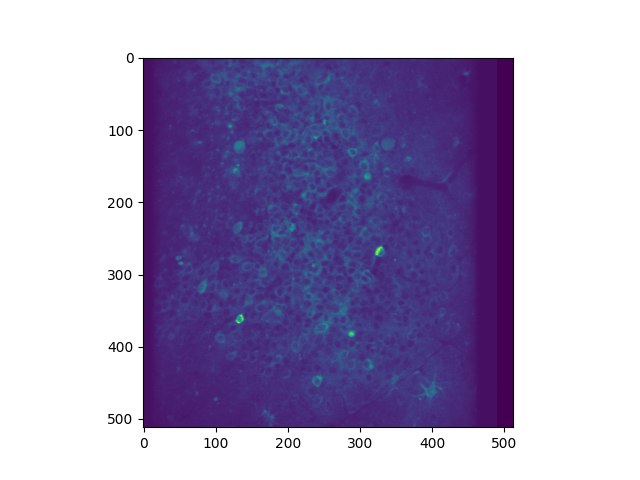

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


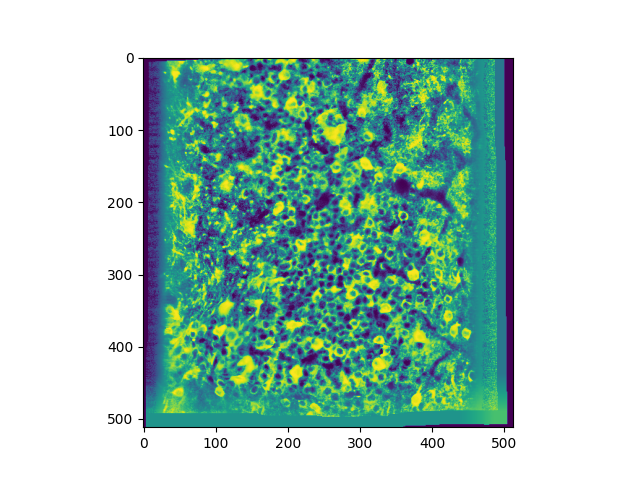

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


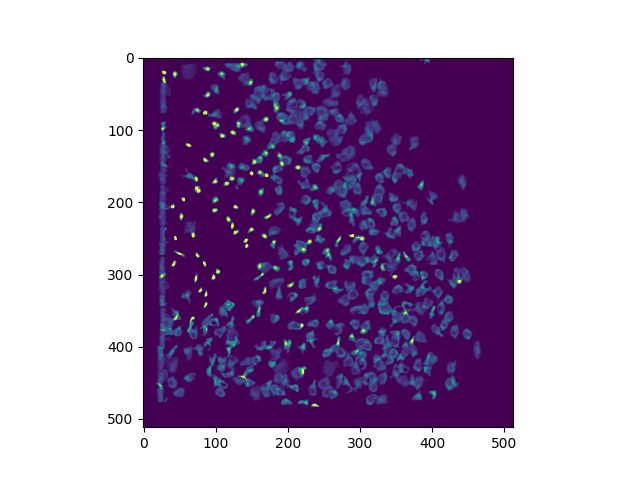

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


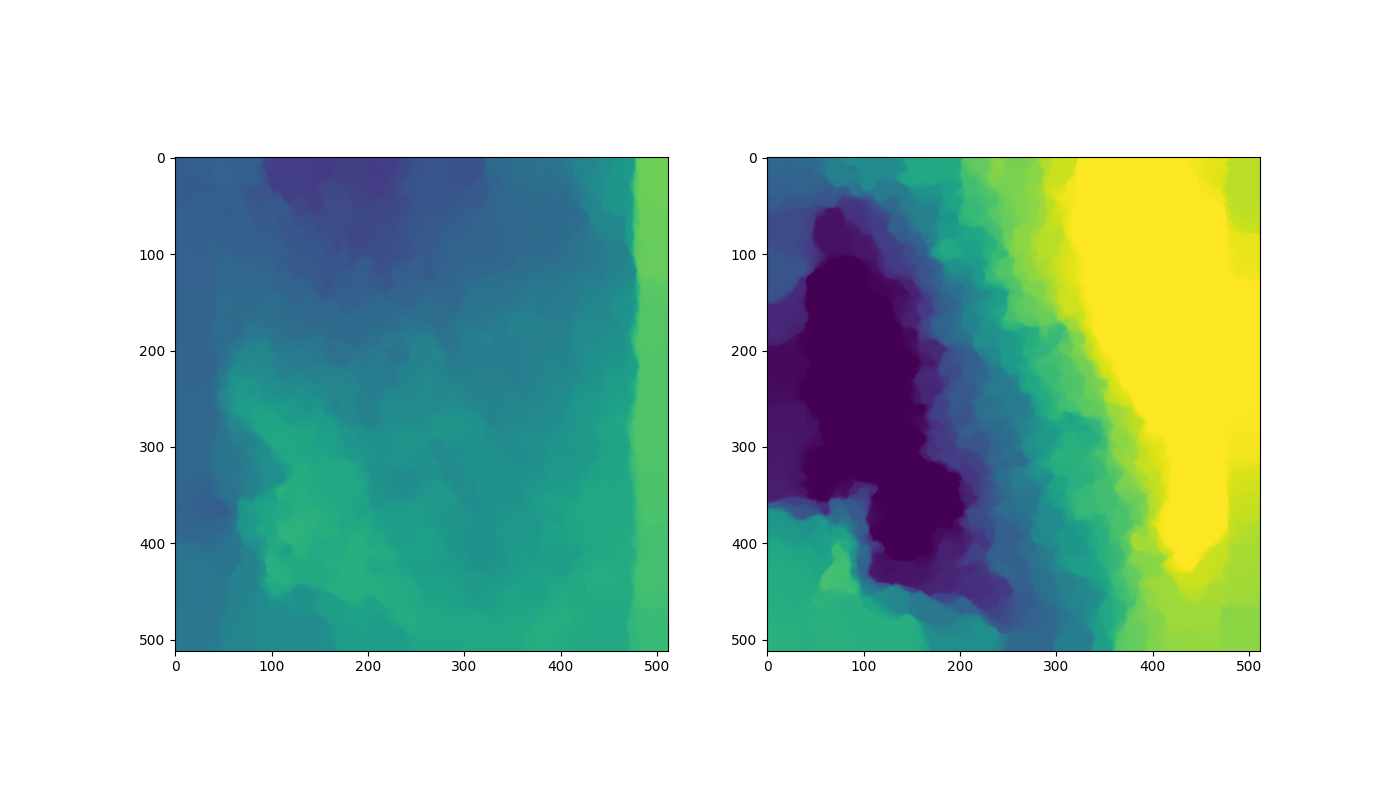

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [15]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

## Blur ROIs (optional)

In [103]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=5,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

<IPython.core.display.Javascript object>


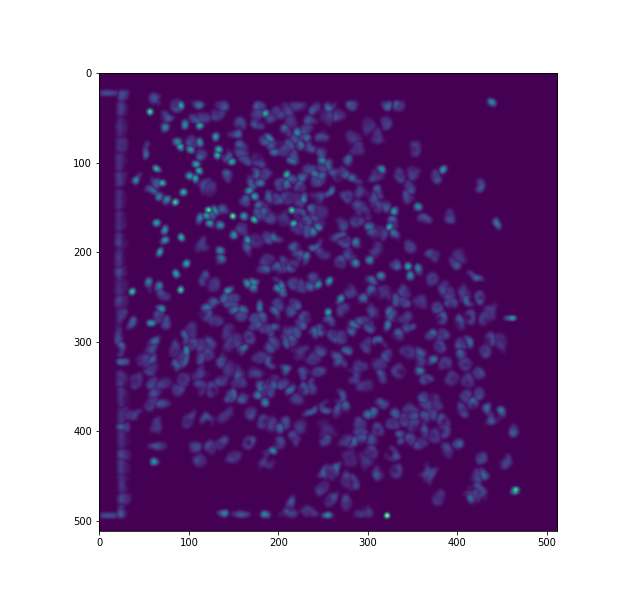

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [105]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [38]:
# hash_dict_true = {
#     'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
#     'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
#     'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
# }
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
#     gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
#     gDriveID='1Xh02nfw_Fgb9uih1WCrsFNI-WIYXDVDn',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

roinet.generate_latents();

# visualization.display_toggle_image_stack(roinet.ROI_images_rs)

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  8.47it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                   | 0/881 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [26]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [93]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


71it [00:00, 317.14it/s]                                                        

Completed: SWT transform on ROIs


In [94]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


## Compute similarities

In [95]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=data.FOV_height,
    block_width=data.FOV_width,
    overlapping_width_Multiplier=0.0,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1.0,
    verbose=True,
)

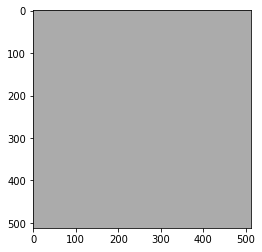

In [96]:
sim.visualize_blocks()

In [106]:
s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=helpers.bounded_logspace(0.02, 3, 70),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=300,
);

Computing pairwise similarity between ROIs...


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


In [108]:
sim.make_normalized_similarities(
    centers_of_mass=data.get_midCoords(),
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    k_max=3000,
    k_min=100,
    algo_NN='kd_tree',
)

100%|██████████████████████████████████████| 7047/7047 [00:26<00:00, 270.99it/s]


# Clustering

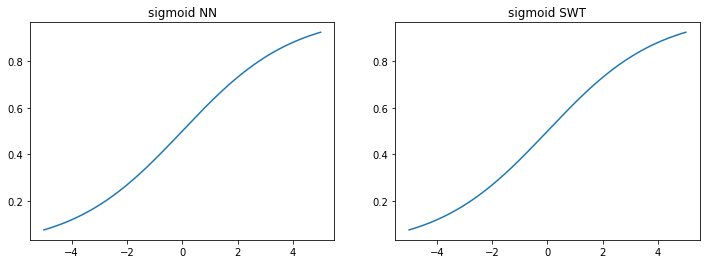

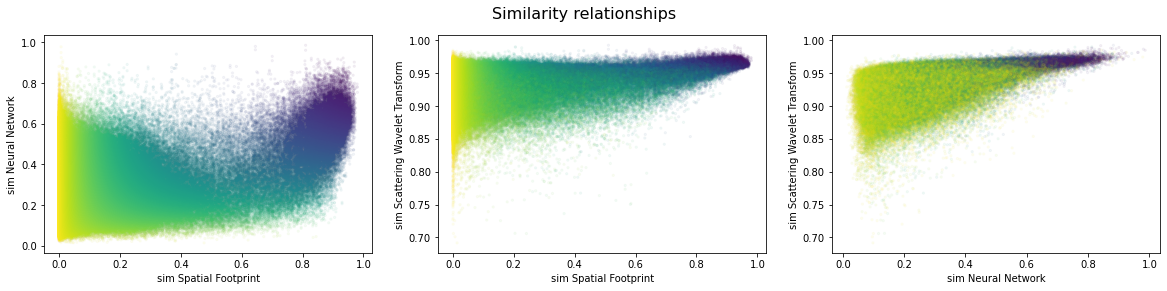

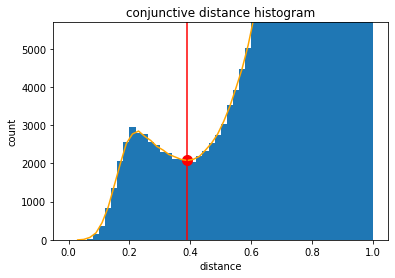

In [109]:
%matplotlib inline
clusterer = clustering.Clusterer()

clusterer.make_conjunctive_distance_matrix(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    power_sf=1,
    power_NN=2,
    power_SWT=0.1,
    p_norm=-1,
    sig_NN_kwargs={'mu':0.0, 'b':0.5},
    sig_SWT_kwargs={'mu':0.0, 'b':0.5},
    plot_sigmoid=True,
)

# %matplotlib inline
clusterer.plot_similarity_relationships(plots_to_show=[1,2,3])

clusterer.find_intermode_cutoff(
    n_bins=50, 
    smoothing_window=3,
    plot_pref=True
)

In [110]:
labels = clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    discard_failed_pruning=True,
);

RH WARNING: Redundant session cluster splitting did not complete fully. Distance walk failed at 'd_cut':0.009988285482344055.
Setting all clusters with redundant ROIs to label: -1.


In [101]:
# results_clustering = clustering.score_labels(clusterer.labels, ucids_groundTruth, ignore_negOne=False)
# print(f"Accuracy score: {results_clustering['score_weighted_partial']}")

# # results_clustering

# print(len(np.unique(labels)), len(np.unique(ucids_groundTruth)))
# print((labels==-1).sum())
# print((ucids_groundTruth==-1).sum())

# Visualize results

In [54]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=labels,
    confidence=None,
    threshold_confidence = 0.5
)

<IPython.core.display.Javascript object>


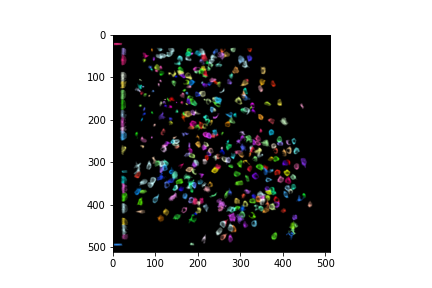

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [67]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

In [266]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_4562/2710547728.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


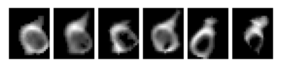

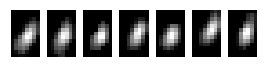

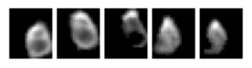

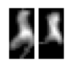

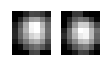

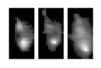

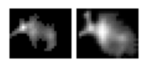

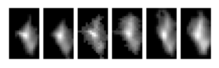

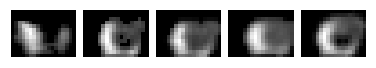

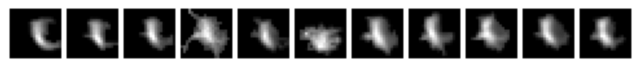

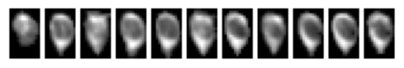

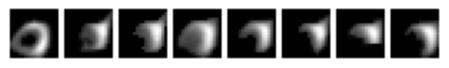

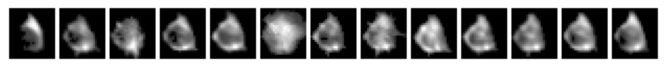

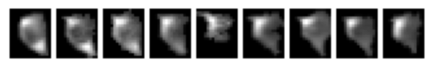

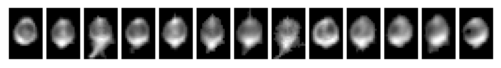

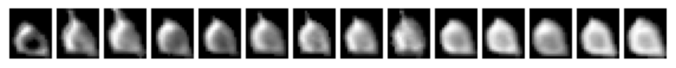

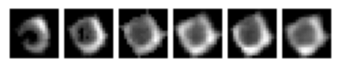

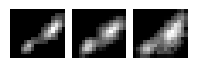

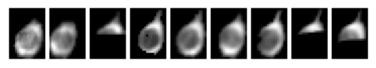

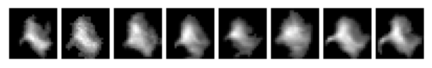

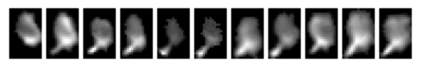

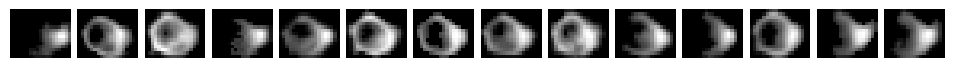

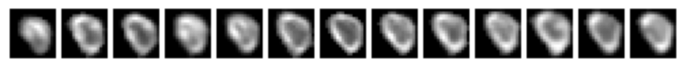

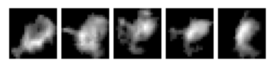

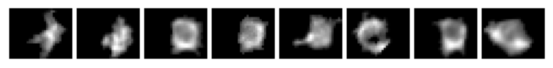

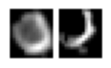

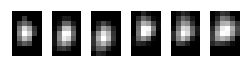

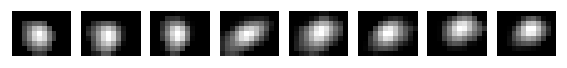

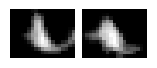

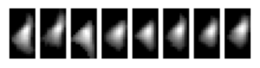

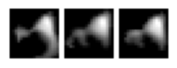

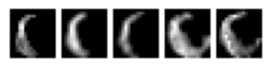

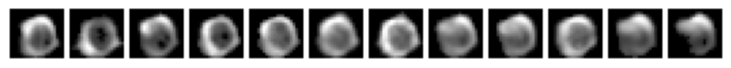

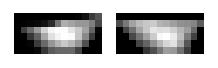

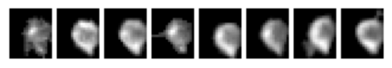

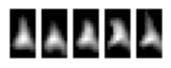

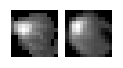

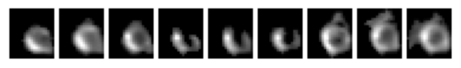

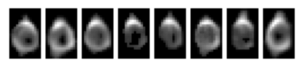

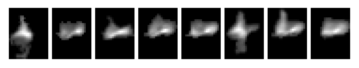

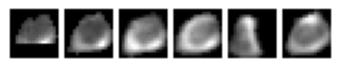

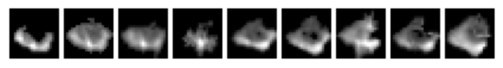

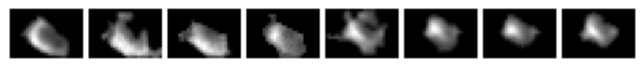

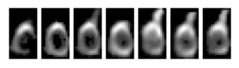

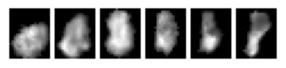

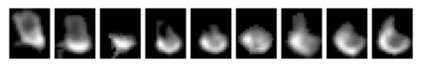

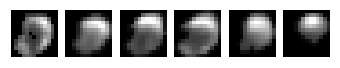

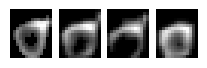

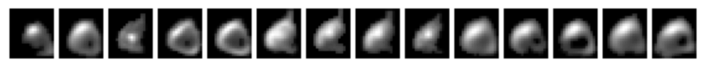

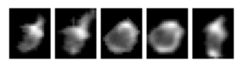

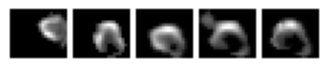

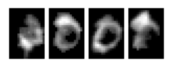

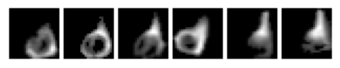

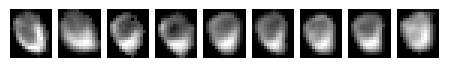

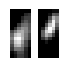

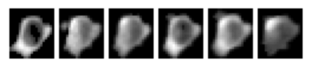

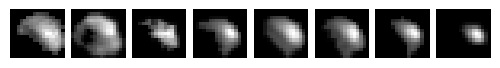

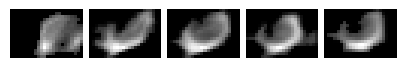

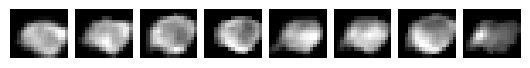

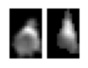

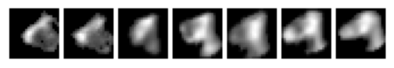

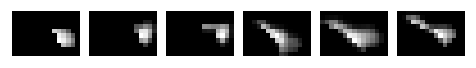

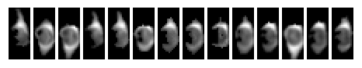

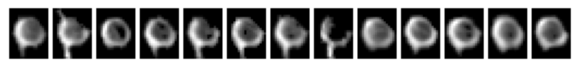

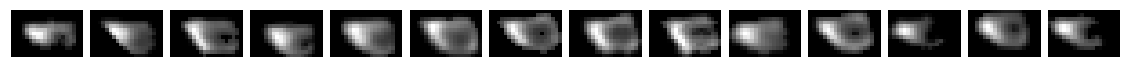

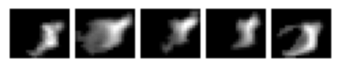

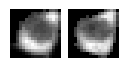

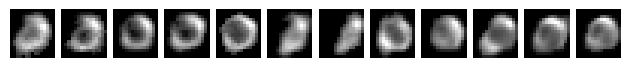

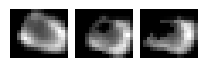

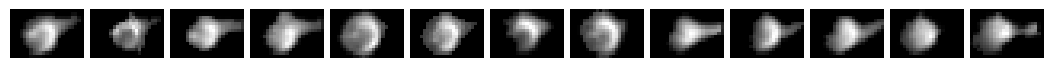

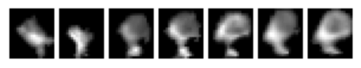

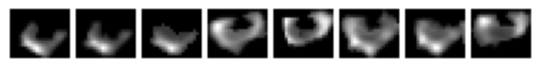

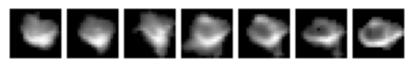

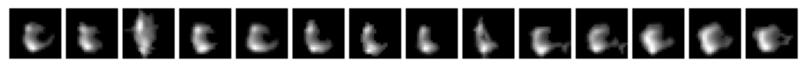

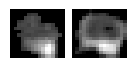

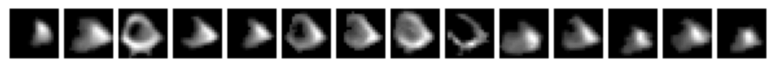

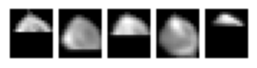

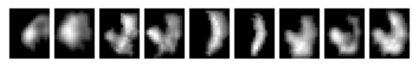

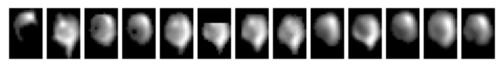

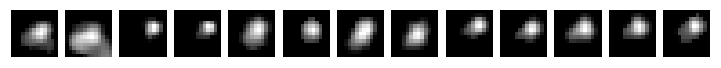

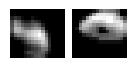

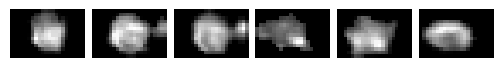

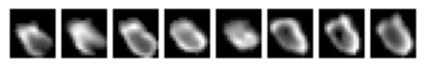

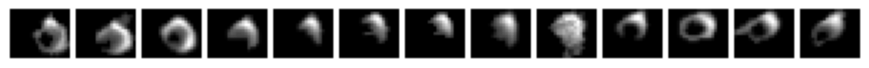

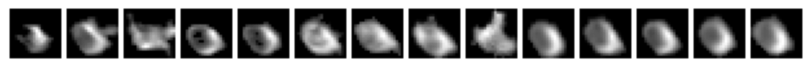

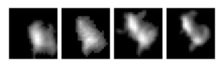

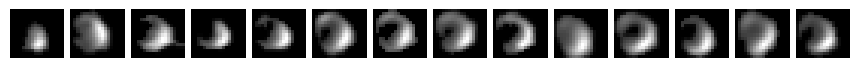

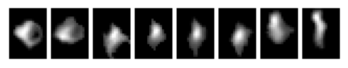

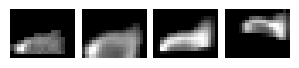

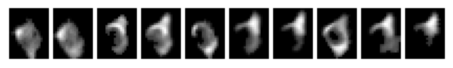

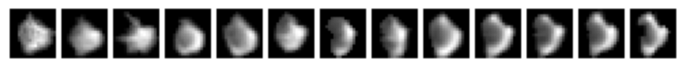

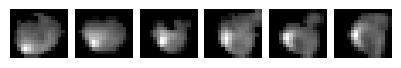

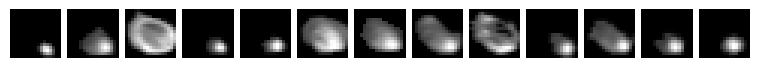

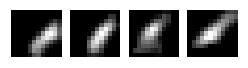

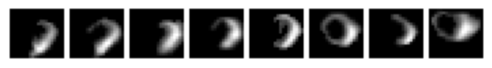

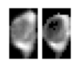

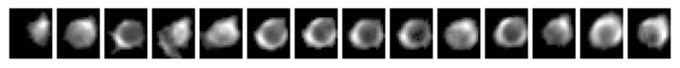

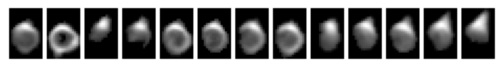

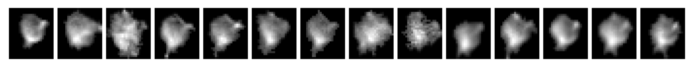

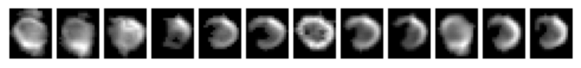

In [111]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

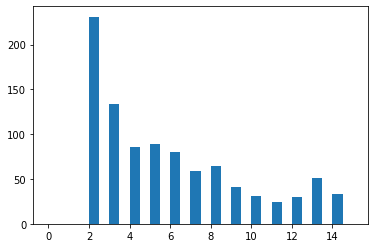

In [114]:
_, counts = np.unique(ucids, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


# Save results

In [60]:
dir_save = Path('/home/rich/Desktop/').resolve()
name_save = dir_allOuterFolders.name

In [ ]:
preds_bySession = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

helpers.simple_save(
    {
        "UCIDs": list(clusterAssigner.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_bySession,
        "ROIs": ROIs,
    },
    filename=dir_save / (name_save + '.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)

In [115]:
import scipy.io

In [116]:
test = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044_manually_aligned.mat', simplify_cells=True)

In [117]:
test['this_mouse']['ud']['sismat']

array([[ nan,  nan, 282., ...,  63.,  70.,  77.],
       [ 85., 359.,  nan, ...,  nan,  nan,  nan],
       [399.,  70.,  nan, ...,  nan,  nan,  nan],
       ...,
       [182., 310.,  nan, ..., 161., 324., 335.],
       [511.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [118]:
sismat = test['this_mouse']['ud']['sismat']

In [119]:
ucid_gt = [np.ones(data.n_roi[ii])*-1 for ii in range(data.n_sessions)]

for sesh in range(sismat.shape[1]):
    for ii in range(sismat.shape[0]):
        idx = sismat[:,sesh][ii] -1
        if np.isnan(idx) == False:
#             print(sesh, idx, ii)
            ucid_gt[sesh][int(idx)] = ii

In [120]:
_, counts = np.unique(np.concatenate(ucid_gt), return_counts=True)

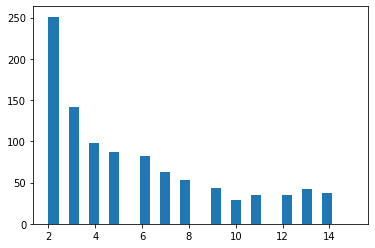

In [123]:
plt.figure()
plt.hist(counts, 30, range=(2, data.n_sessions+1));

<IPython.core.display.Javascript object>


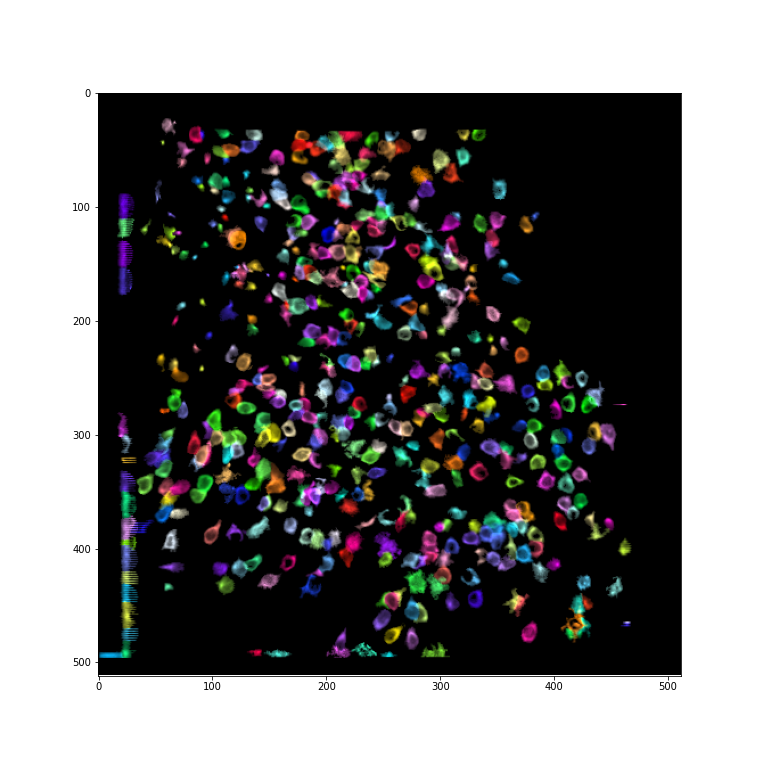

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [367]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=np.concatenate(ucid_gt),
    confidence=None,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)